In [19]:
%matplotlib inline

#Enable reloading because restarting the kernel is a pain
%load_ext autoreload
%autoreload 2

import shapely
from shapely.geometry import Polygon

import matplotlib.pyplot as plt
import numpy as np

from bot_2d_rep import *
from bot_2d_problem import *

import copy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Set up & run the simple optimization problem

In [20]:
from pymoo.problems.functional import FunctionalProblem

sensor_bounds = Polygon([(.1,.1), (-.1,.1),(-.1,-.2),(.1,-.2)])

sensor_options = [FOV2D_Simple(hfov=90, distance=12, cost=80.00, color="purple", bounds_polygon=copy.deepcopy(sensor_bounds)),
                  FOV2D_Simple(hfov=270, distance=10, cost=200.00, color="green", bounds_polygon=copy.deepcopy(sensor_bounds)),
                  FOV2D_Simple(hfov=60, distance=20, cost=150.00, color="orange", bounds_polygon=copy.deepcopy(sensor_bounds)),
                  FOV2D_Simple(hfov=75, distance=9, cost=30.00, color="pink", bounds_polygon=copy.deepcopy(sensor_bounds))]

bot_diam = 1
bot_bounds = Polygon([(-1, -2), (-1, 2), (1, 2), (1, -2)])
sens_constraint = Polygon(shapely.geometry.Point(0, 0).buffer(bot_diam+.1).exterior.buffer(0.2))
sense_requirement =  Polygon(shapely.geometry.Point(0, 0).buffer(12).exterior.coords)
sense_requirement = shapely.affinity.scale(sense_requirement, xfact=2/3, yfact=1, origin=(0, 0))
sense_requirement = shapely.affinity.translate(sense_requirement, xoff=0, yoff=4)

bot = SimpleBot2d(bot_bounds, sense_requirement, sensor_pose_constraint=sens_constraint)

In [21]:
from pymoo.algorithms.moo.nsga2 import NSGA2, RankAndCrowdingSurvival
from pymoo.core.mixed import MixedVariableGA
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling

problem = SensorPkgOptimization(bot, sensor_options, 5)

algorithm = MixedVariableGA(
    pop_size=100,
    n_offsprings=50,
    sampling=CustomSensorPkgRandomSampling(),
    survival=RankAndCrowdingSurvival()
)

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |      100 |  0.3165251881 |  0.3545449673
     2 |      150 |  0.3213687526 |  0.3545449673
     3 |      200 |  0.3204502559 |  0.3545449673
     4 |      250 |  0.3274133443 |  0.3545449673
     5 |      300 |  0.3266349656 |  0.3545449673
     6 |      350 |  0.3190137243 |  0.3545449673
     7 |      400 |  0.3173887705 |  0.3545449673
     8 |      450 |  0.3158652165 |  0.3545449673
     9 |      500 |  0.3156228748 |  0.3545449673
    10 |      550 |  0.3198263635 |  0.3545449673
    11 |      600 |  0.3280034972 |  0.3545449673
    12 |      650 |  0.3361551525 |  0.3545449673
    13 |      700 |  0.3247551260 |  0.3545449673
    14 |      750 |  0.3213329011 |  0.3545449673
    15 |      800 |  0.3244660213 |  0.3545449673
    16 |      850 |  0.3241502982 |  0.0349451487
    17 |      900 |  0.3308282847 |  0.0349451487
    18 |      950 |  0.3163150573 |  0.0349451487
    19 |     1000 |  0.3188847653 |  0.0349451487


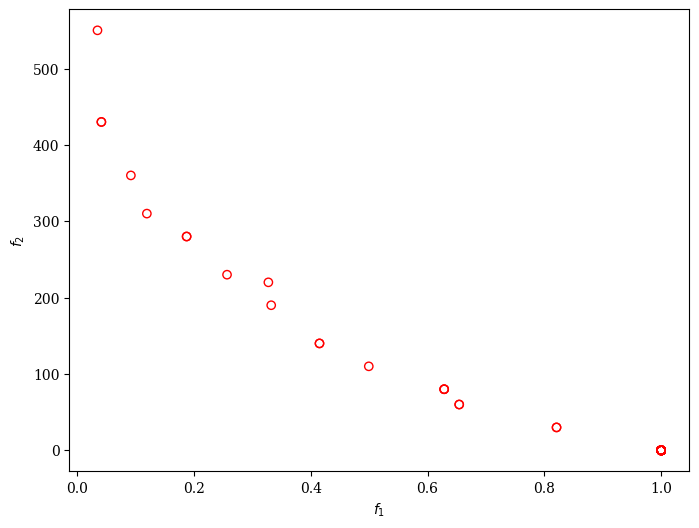

In [22]:

res = minimize(problem,
               algorithm,
               ('n_gen', 500),
               seed=1,
               verbose=True)

pareto_front = problem.pareto_front(use_cache=False, flatten=False)
plot = Scatter()
plot.add(pareto_front, plot_type="line", color="black", alpha=0.7)
plot.add(res.F, facecolor="none", edgecolor="red")
plot.show()

In [23]:
import pandas as pd

import plotly.express as px

results = res.F

# Create a DataFrame from the results
df_results = pd.DataFrame(results, columns=['Perception Coverage', 'Cost'])
df_results['Perception Coverage'] = (1- df_results['Perception Coverage']) * 100
df_results['Index'] = df_results.index

# Create the scatter plot
fig = px.scatter(df_results, x='Cost', y='Perception Coverage', hover_data=['Index'], title=f"Objective Space (generated {results.shape[0]} concepts)", template="plotly_white")

# Show the plot
fig.show()
df_results


,Perception Coverage,Cost,Index
0,0.000000,0.0,0
1,96.517431,550.0,1
2,0.000000,0.0,2
3,50.059541,110.0,3
4,90.798609,360.0,4
...,...,...,...
95,0.000000,0.0,95
96,0.000000,0.0,96
97,0.000000,0.0,97
98,0.000000,0.0,98


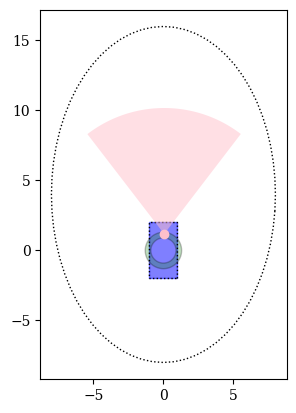

In [37]:
bot_plot = problem.convert_1D_to_bot(res.X[10]).plot_bot(show_constraint=True)